Preprocessing

In [1]:
import os
import pandas as pd
from pathlib import Path
from datasets import load_dataset, DownloadMode, DatasetDict
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [3]:
destination_path = '\Data'

dataset_emotion = load_dataset(
    "dair-ai/emotion", "unsplit", 
    cache_dir=destination_path,
    download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS
)

print(dataset_emotion)

# Get class names from dataset features
class_names = dataset_emotion['train'].features['label'].names

# Add new column mapping numeric labels to class names using Dataset.map
dataset_emotion['train'] = dataset_emotion['train'].map(
    lambda example: {'label_name': class_names[example['label']]}
)

# Konverter det fulde datasæt til en pandas DataFrame
df_samlet = dataset_emotion['train'].to_pandas()

df_samlet['text_length'] = df_samlet['text'].apply(len)


<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\klykk\AppData\Local\Temp\ipykernel_7980\831718421.py:1: SyntaxWarning: invalid escape sequence '\D'
  destination_path = '\Data'


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 416809
    })
})


Is the train, test og validation split appropriate?

In [4]:
destination_path = '\Data'

dataset_emotion_split = load_dataset(
    "dair-ai/emotion", "split", 
    cache_dir=destination_path,
    download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS
)

print(dataset_emotion_split)

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\klykk\AppData\Local\Temp\ipykernel_7980\2259323051.py:1: SyntaxWarning: invalid escape sequence '\D'
  destination_path = '\Data'


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [5]:
# Get class names from dataset features
class_names_train = dataset_emotion_split['train'].features['label'].names
class_names_val = dataset_emotion_split['validation'].features['label'].names
class_names_test = dataset_emotion_split['test'].features['label'].names

# Add new column mapping numeric labels to class names using Dataset.map
dataset_emotion_split['train'] = dataset_emotion_split['train'].map(
    lambda example: {'label_name': class_names_train[example['label']]}
)

dataset_emotion_split['validation'] = dataset_emotion_split['validation'].map(
    lambda example: {'label_name': class_names_val[example['label']]}
)

dataset_emotion_split['test'] = dataset_emotion_split['test'].map(
    lambda example: {'label_name': class_names_test[example['label']]}
)

# Konverter det fulde datasæt til en pandas DataFrame
df_train = dataset_emotion_split['train'].to_pandas()
df_val = dataset_emotion_split['validation'].to_pandas()
df_test = dataset_emotion_split['test'].to_pandas()

# Kontroller for manglende værdier
mis_val_train = df_train.isnull().sum()
mis_val_val = df_val.isnull().sum()
mis_val_test = df_test.isnull().sum()

print('Number of missing values:')
print(mis_val_train,mis_val_val, mis_val_test)

Number of missing values:
text          0
label         0
label_name    0
dtype: int64 text          0
label         0
label_name    0
dtype: int64 text          0
label         0
label_name    0
dtype: int64


Minimum text length (train, val, test):(7,11,14)
Maximum text length(train, val, test):(300,295,296)
Average text length(train, val, test):(96.8458125,95.3475,96.5865)


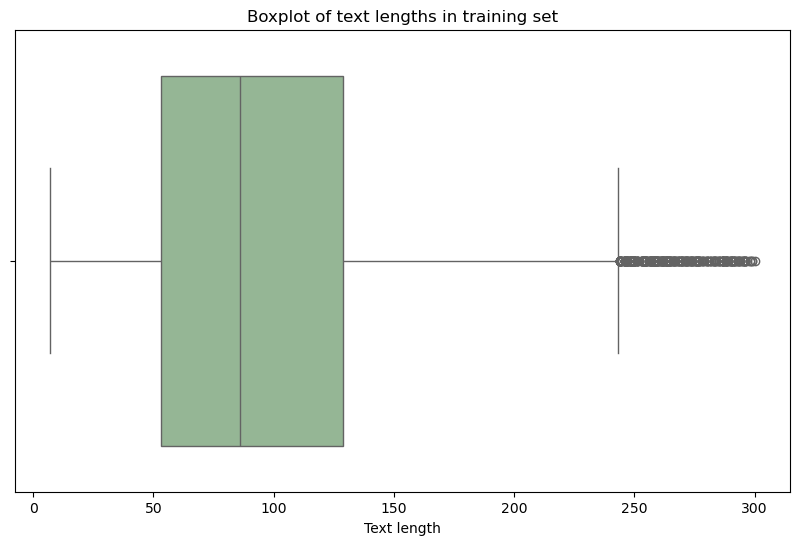

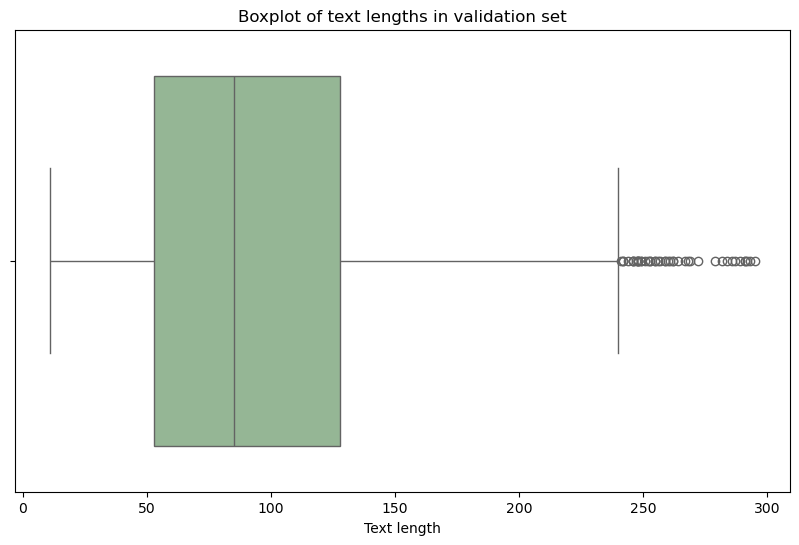

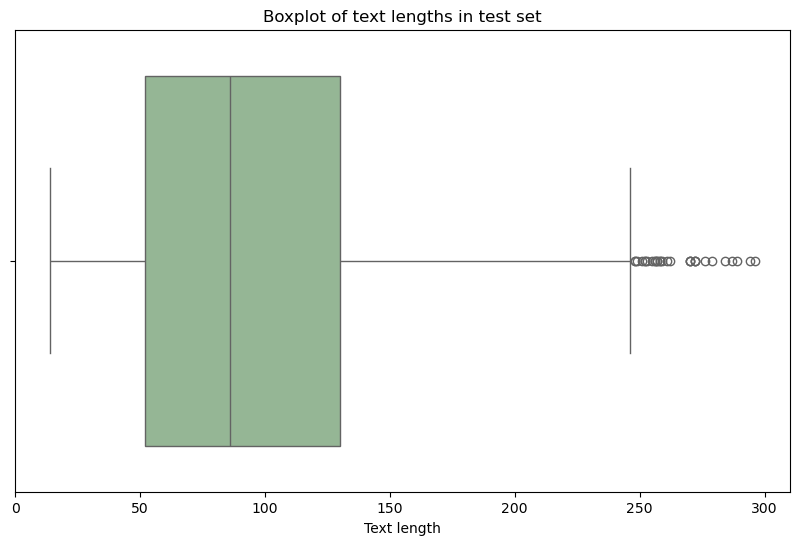

In [8]:
df_train['text_length'] = df_train['text'].apply(len)
df_val['text_length'] = df_val['text'].apply(len)
df_test['text_length'] = df_test['text'].apply(len)

print(f'Minimum text length (train, val, test):({df_train['text_length'].min()},{df_val['text_length'].min()},{df_test['text_length'].min()})')
print(f'Maximum text length(train, val, test):({df_train['text_length'].max()},{df_val['text_length'].max()},{df_test['text_length'].max()})')
print(f'Average text length(train, val, test):({df_train['text_length'].mean()},{df_val['text_length'].mean()},{df_test['text_length'].mean()})')

# train
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_train['text_length'], color='darkseagreen')
plt.title('Boxplot of text lengths in training set')
plt.xlabel('Text length')
plt.show()

# validation
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_val['text_length'], color='darkseagreen')
plt.title('Boxplot of text lengths in validation set')
plt.xlabel('Text length')
plt.show()

# test
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_test['text_length'], color='darkseagreen')
plt.title('Boxplot of text lengths in test set')
plt.xlabel('Text length')
plt.show()


In [24]:
# Removing outliers in unsplit-dataset
# Beregn Q1 (25. percentil), Q3 (75. percentil) og IQR
q1_samlet = np.percentile(df_samlet['text_length'], 25)
q3_samlet = np.percentile(df_samlet['text_length'], 75)
iqr_samlet = q3_samlet - q1_samlet

# Beregn max-værdien (øverste grænse for ikke-outliers)
upper_whisker_samlet = q3_samlet + 1.5 * iqr_samlet

print(f'Q1: {q1_samlet}, Q3: {q3_samlet}, IQR: {iqr_samlet}, Upper whisker: {upper_whisker_samlet}')


max_non_outlier_samlet = df_samlet['text_length'][df_samlet['text_length'] <= upper_whisker_samlet].max()
number_outliers_samlet = df_samlet['text_length'][df_samlet['text_length'] > upper_whisker_samlet].count()

print(f'Maximum non-outlier text length: {max_non_outlier_samlet}, Number of outliers in df_samlet: {number_outliers_samlet}')

df_samlet_no_out = df_samlet[df_samlet['text_length'] <= upper_whisker_samlet]
print(df_samlet_no_out.head(2))

rows_samlet, columns_samlet = df_samlet.shape
rows_samlet_no_out, columns_samlet_no_out = df_samlet_no_out.shape
print(f'Length of df_samlet before removing outliers: {rows_samlet}, Length of df_samlet after removing outliers: {rows_samlet_no_out}, Number of outliers removed: {rows_samlet-rows_samlet_no_out}')



# Removing outliers in split-dataset
# Train
# Beregn Q1 (25. percentil), Q3 (75. percentil) og IQR
q1_train = np.percentile(df_train['text_length'], 25)
q3_train = np.percentile(df_train['text_length'], 75)
iqr_train = q3_train - q1_train

# Beregn max-værdien (øverste grænse for ikke-outliers)
upper_whisker_train = q3_train + 1.5 * iqr_train

print(f'Q1: {q1_train}, Q3: {q3_train}, IQR: {iqr_train}, Upper whisker: {upper_whisker_train}')


max_non_outlier_train = df_train['text_length'][df_train['text_length'] <= upper_whisker_train].max()
number_outliers_train = df_train['text_length'][df_train['text_length'] > upper_whisker_train].count()

print(f'Maximum non-outlier text length: {max_non_outlier_train}, Number of outliers in df_train: {number_outliers_train}')

df_train_no_out = df_train[df_train['text_length'] <= upper_whisker_train]
print(df_train_no_out.head(2))

rows_train, columns_train = df_train.shape
rows_train_no_out, columns_train_no_out = df_train_no_out.shape
print(f'Length of df_train before removing outliers: {rows_train}, Length of df_train after removing outliers: {rows_train_no_out}, Number of outliers removed: {rows_train-rows_train_no_out}')


# Validation
# Beregn Q1 (25. percentil), Q3 (75. percentil) og IQR
q1_val = np.percentile(df_val['text_length'], 25)
q3_val = np.percentile(df_val['text_length'], 75)
iqr_val = q3_val - q1_val

# Beregn max-værdien (øverste grænse for ikke-outliers)
upper_whisker_val = q3_val + 1.5 * iqr_val

print(f'Q1: {q1_val}, Q3: {q3_val}, IQR: {iqr_val}, Upper whisker: {upper_whisker_val}')


max_non_outlier_val = df_val['text_length'][df_val['text_length'] <= upper_whisker_val].max()
number_outliers_val = df_val['text_length'][df_val['text_length'] > upper_whisker_val].count()

print(f'Maximum non-outlier text length: {max_non_outlier_val}, Number of outliers in df_val: {number_outliers_val}')

df_val_no_out = df_val[df_val['text_length'] <= upper_whisker_val]
print(df_val_no_out.head(2))

rows_val, columns_val = df_val.shape
rows_val_no_out, columns_val_no_out = df_val_no_out.shape
print(f'Length of df_val before removing outliers: {rows_val}, Length of df_val after removing outliers: {rows_val_no_out}, Number of outliers removed: {rows_val-rows_val_no_out}')




# Test
# Beregn Q1 (25. percentil), Q3 (75. percentil) og IQR
q1_test = np.percentile(df_test['text_length'], 25)
q3_test = np.percentile(df_test['text_length'], 75)
iqr_test = q3_test - q1_test

# Beregn max-værdien (øverste grænse for ikke-outliers)
upper_whisker_test = q3_test + 1.5 * iqr_test

print(f'Q1: {q1_test}, Q3: {q3_test}, IQR: {iqr_test}, Upper whisker: {upper_whisker_test}')


max_non_outlier_test = df_test['text_length'][df_test['text_length'] <= upper_whisker_test].max()
number_outliers_test = df_test['text_length'][df_test['text_length'] > upper_whisker_test].count()

print(f'Maximum non-outlier text length: {max_non_outlier_test}, Number of outliers in df_test: {number_outliers_test}')

df_test_no_out = df_test[df_test['text_length'] <= upper_whisker_test]
print(df_test_no_out.head(2))

rows_test, columns_test = df_test.shape
rows_test_no_out, columns_test_no_out = df_test_no_out.shape
print(f'Length of df_test before removing outliers: {rows_test}, Length of df_test after removing outliers: {rows_test_no_out}, Number of outliers removed: {rows_test-rows_test_no_out}')



Q1: 54.0, Q3: 128.0, IQR: 74.0, Upper whisker: 239.0
Maximum non-outlier text length: 239, Number of outliers in df_samlet: 9962
                                                text  label label_name  \
0  i feel awful about it too because it s my job ...      0    sadness   
1                              im alone i feel awful      0    sadness   

   text_length  
0          112  
1           21  
Length of df_samlet before removing outliers: 416809, Length of df_samlet after removing outliers: 406847, Number of outliers removed: 9962
Q1: 53.0, Q3: 129.0, IQR: 76.0, Upper whisker: 243.0
Maximum non-outlier text length: 243, Number of outliers in df_train: 329
                                                text  label label_name  \
0                            i didnt feel humiliated      0    sadness   
1  i can go from feeling so hopeless to so damned...      0    sadness   

   text_length  
0           23  
1          108  
Length of df_train before removing outliers: 16000, Leng

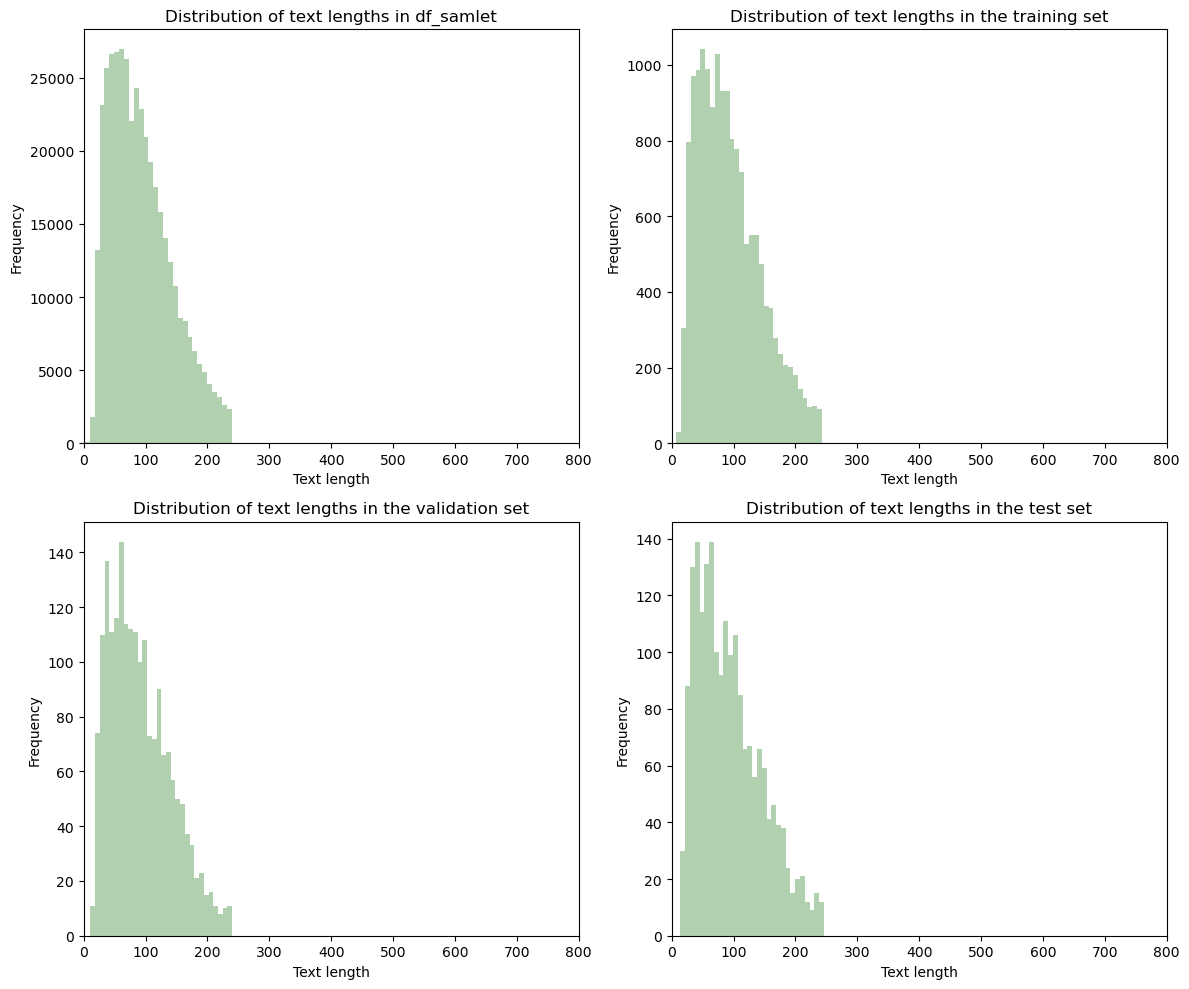

In [25]:
# Data
data1 = df_samlet_no_out['text_length']
data2 = df_train_no_out['text_length']
data3 = df_val_no_out['text_length']
data4 = df_test_no_out['text_length']


# Opret subplots (2 rækker og 2 kolonner)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram 1
axes[0, 0].hist(data1, bins=30, color='darkseagreen', alpha=0.7)
axes[0, 0].set_title('Distribution of text lengths in df_samlet')
axes[0, 0].set_xlabel('Text length')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_xlim(0, 800)

# Histogram 2
axes[0, 1].hist(data2, bins=30, color='darkseagreen', alpha=0.7)
axes[0, 1].set_title('Distribution of text lengths in the training set')
axes[0, 1].set_xlabel('Text length')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_xlim(0, 800)

# Histogram 3
axes[1, 0].hist(data3, bins=30, color='darkseagreen', alpha=0.7)
axes[1, 0].set_title('Distribution of text lengths in the validation set')
axes[1, 0].set_xlabel('Text length')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xlim(0, 800)

# Histogram 4
axes[1, 1].hist(data4, bins=30, color='darkseagreen', alpha=0.7)
axes[1, 1].set_title('Distribution of text lengths in the test set')
axes[1, 1].set_xlabel('Text length')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_xlim(0, 800)

# Juster layout for at få plads til titler og labels
plt.tight_layout()

# Vis plottet
plt.show()


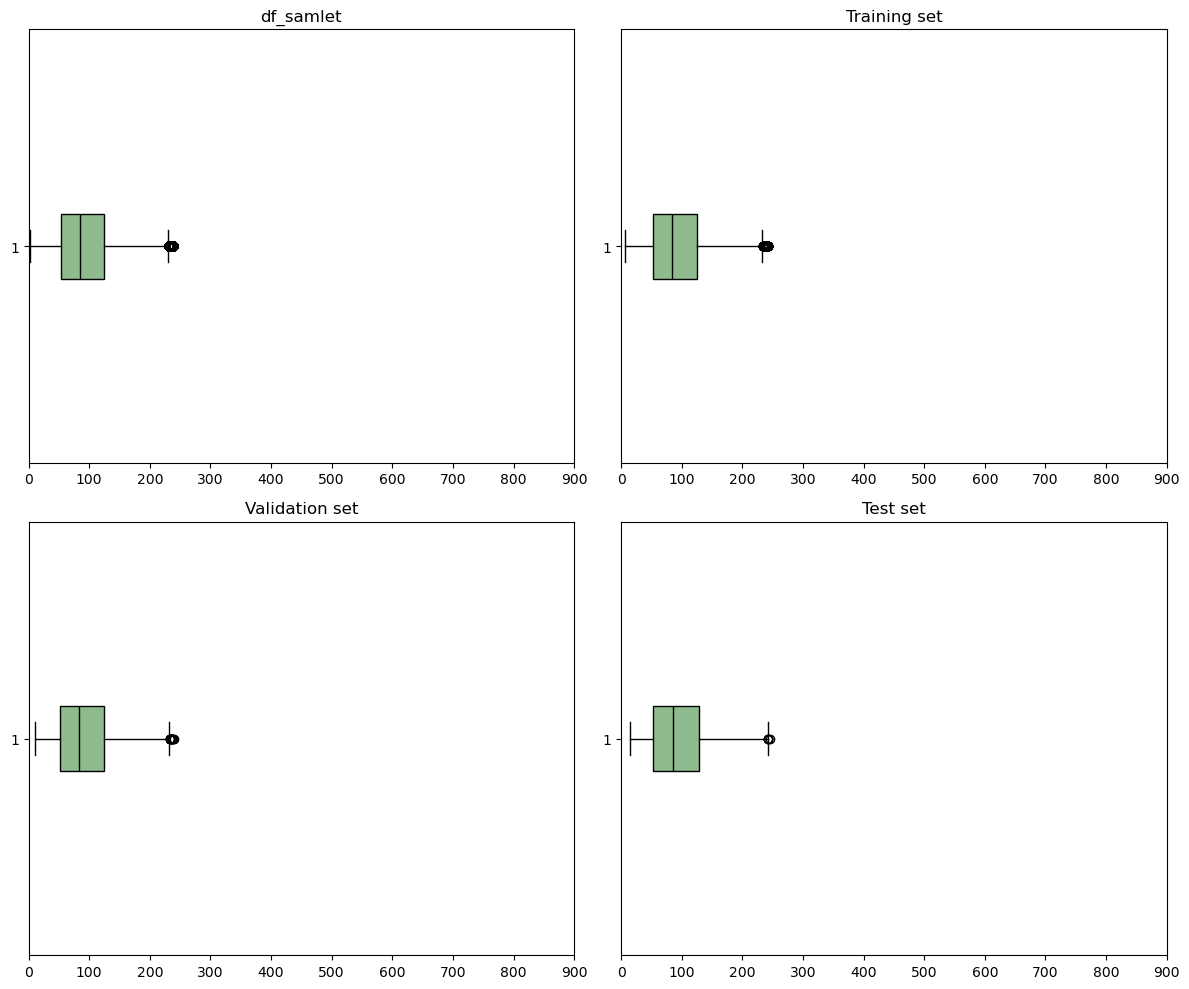

In [26]:
# Data
data1 = df_samlet_no_out['text_length']
data2 = df_train_no_out['text_length']
data3 = df_val_no_out['text_length']
data4 = df_test_no_out['text_length']

# Opret subplots (2 rækker og 2 kolonner)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Boksplot 1
axes[0, 0].boxplot(data1, patch_artist=True, vert=False,
                   boxprops=dict(facecolor='darkseagreen', color='black'),
                   whiskerprops=dict(color='black'),
                   capprops=dict(color='black'),
                   medianprops=dict(color='black'))
axes[0, 0].set_title('df_samlet')
axes[0, 0].set_xlim(0, 900)


# Boksplot 2
axes[0, 1].boxplot(data2, patch_artist=True, vert=False,
                   boxprops=dict(facecolor='darkseagreen', color='black'),
                   whiskerprops=dict(color='black'),
                   capprops=dict(color='black'),
                   medianprops=dict(color='black'))
axes[0, 1].set_title('Training set')
axes[0, 1].set_xlim(0, 900)

# Boksplot 3
axes[1, 0].boxplot(data3, patch_artist=True, vert=False,
                   boxprops=dict(facecolor='darkseagreen', color='black'),
                   whiskerprops=dict(color='black'),
                   capprops=dict(color='black'),
                   medianprops=dict(color='black'))
axes[1, 0].set_title('Validation set')
axes[1, 0].set_xlim(0, 900)

# Boksplot 4
axes[1, 1].boxplot(data4, patch_artist=True, vert=False,
                   boxprops=dict(facecolor='darkseagreen', color='black'),
                   whiskerprops=dict(color='black'),
                   capprops=dict(color='black'),
                   medianprops=dict(color='black'))
axes[1, 1].set_title('Test set')
axes[1, 1].set_xlim(0, 900)


# Juster layout for at få plads til titler og labels
plt.tight_layout()

# Vis plottet
plt.show()


In [27]:
# largest outlier

outlier1 = df_samlet_no_out['text_length'].max()
outlier2 = df_train_no_out['text_length'].max()
outlier3 = df_val_no_out['text_length'].max()
outlier4 = df_test_no_out['text_length'].max()

print(outlier1, outlier2, outlier3, outlier4)

239 243 240 246


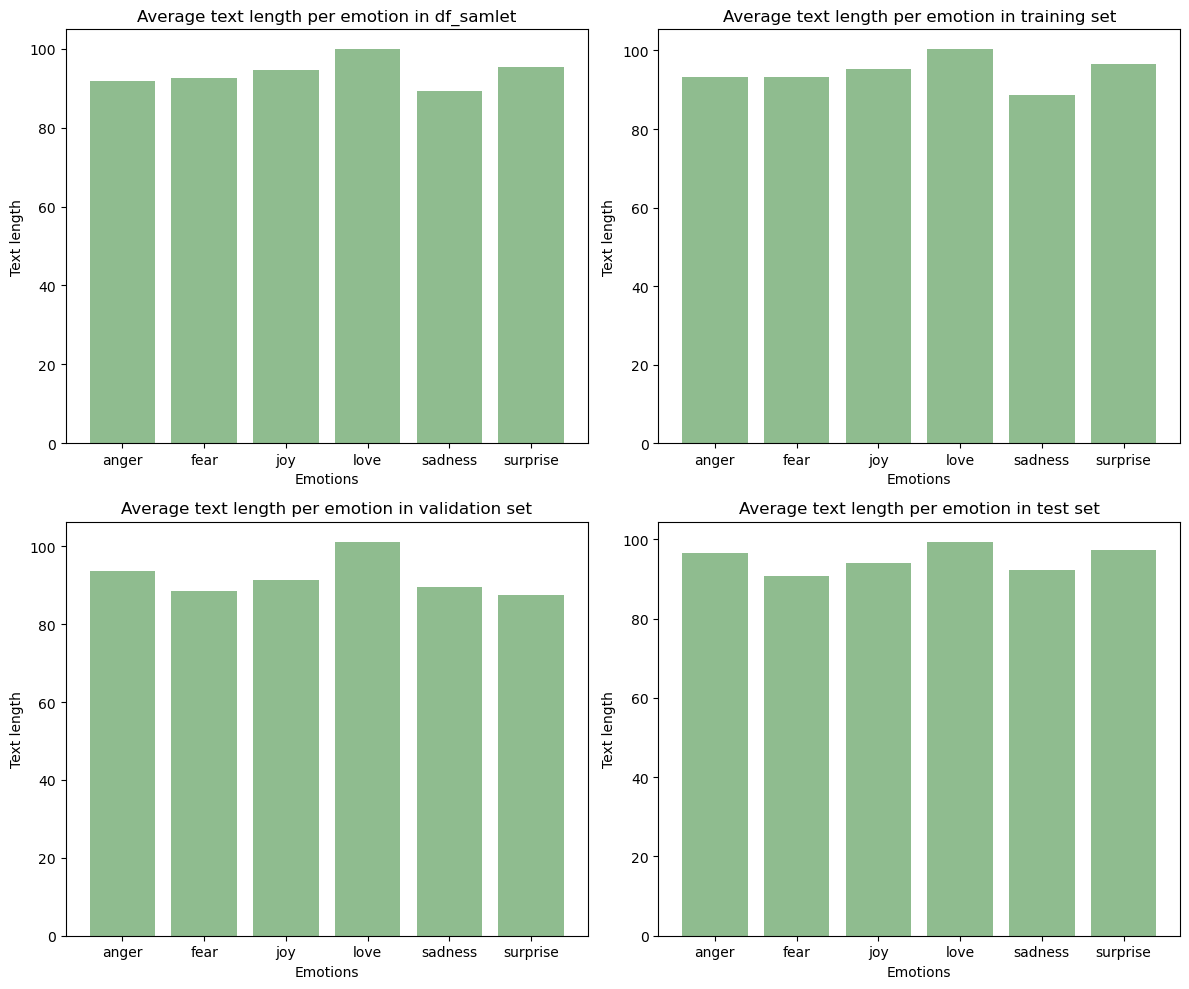

In [28]:
groups_mean_length = df_samlet_no_out.groupby('label_name')['text_length'].mean()
groups_mean_train = df_train_no_out.groupby('label_name')['text_length'].mean()
groups_mean_val = df_val_no_out.groupby('label_name')['text_length'].mean()
groups_mean_test = df_test_no_out.groupby('label_name')['text_length'].mean()

# Opret subplots (2 rækker og 2 kolonner)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Bar chart 1
axes[0, 0].bar(groups_mean_length.index, groups_mean_length.values, color='darkseagreen')
axes[0, 0].set_title('Average text length per emotion in df_samlet')
axes[0, 0].set_xlabel('Emotions')
axes[0, 0].set_ylabel('Text length')

# Bar chart 2
axes[0, 1].bar(groups_mean_train.index, groups_mean_train.values, color='darkseagreen')
axes[0, 1].set_title('Average text length per emotion in training set')
axes[0, 1].set_xlabel('Emotions')
axes[0, 1].set_ylabel('Text length')

# Bar chart 3
axes[1, 0].bar(groups_mean_val.index, groups_mean_val.values, color='darkseagreen')
axes[1, 0].set_title('Average text length per emotion in validation set')
axes[1, 0].set_xlabel('Emotions')
axes[1, 0].set_ylabel('Text length')

# Bar chart 4
axes[1, 1].bar(groups_mean_test.index, groups_mean_test.values, color='darkseagreen')
axes[1, 1].set_title('Average text length per emotion in test set')
axes[1, 1].set_xlabel('Emotions')
axes[1, 1].set_ylabel('Text length')

# Juster layout for at få plads til titler og labels
plt.tight_layout()

# Vis plottet
plt.show()


Distribution of emotions

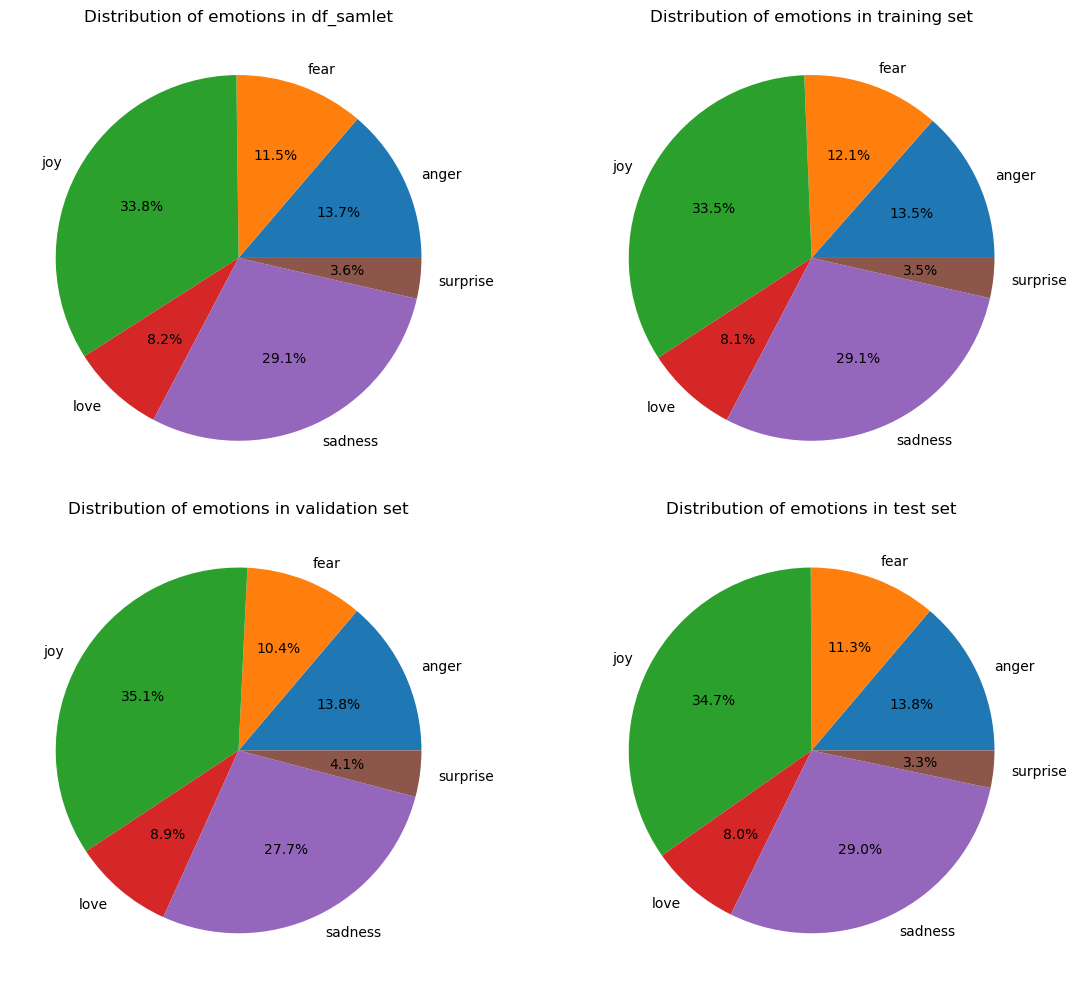

In [29]:
# Data
groups_samlet = df_samlet_no_out.groupby('label_name')['text'].count()
groups_train = df_train_no_out.groupby('label_name')['text'].count()
groups_val = df_val_no_out.groupby('label_name')['text'].count()
groups_test = df_test_no_out.groupby('label_name')['text'].count()

# Opret subplots (2 rækker og 2 kolonner)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Bar chart 1
axes[0, 0].pie(groups_samlet.values, labels=list(groups_samlet.index),autopct='%1.1f%%')
axes[0, 0].set_title('Distribution of emotions in df_samlet')

# Bar chart 2
axes[0, 1].pie(groups_train.values, labels=list(groups_train.index),autopct='%1.1f%%')
axes[0, 1].set_title('Distribution of emotions in training set')

# Bar chart 3
axes[1, 0].pie(groups_val.values, labels=list(groups_val.index),autopct='%1.1f%%')
axes[1, 0].set_title('Distribution of emotions in validation set')

# Bar chart 4
axes[1, 1].pie(groups_test.values, labels=list(groups_test.index),autopct='%1.1f%%')
axes[1, 1].set_title('Distribution of emotions in test set')

# Juster layout for at få plads til titler og labels
plt.tight_layout()

# Vis plottet
plt.show()

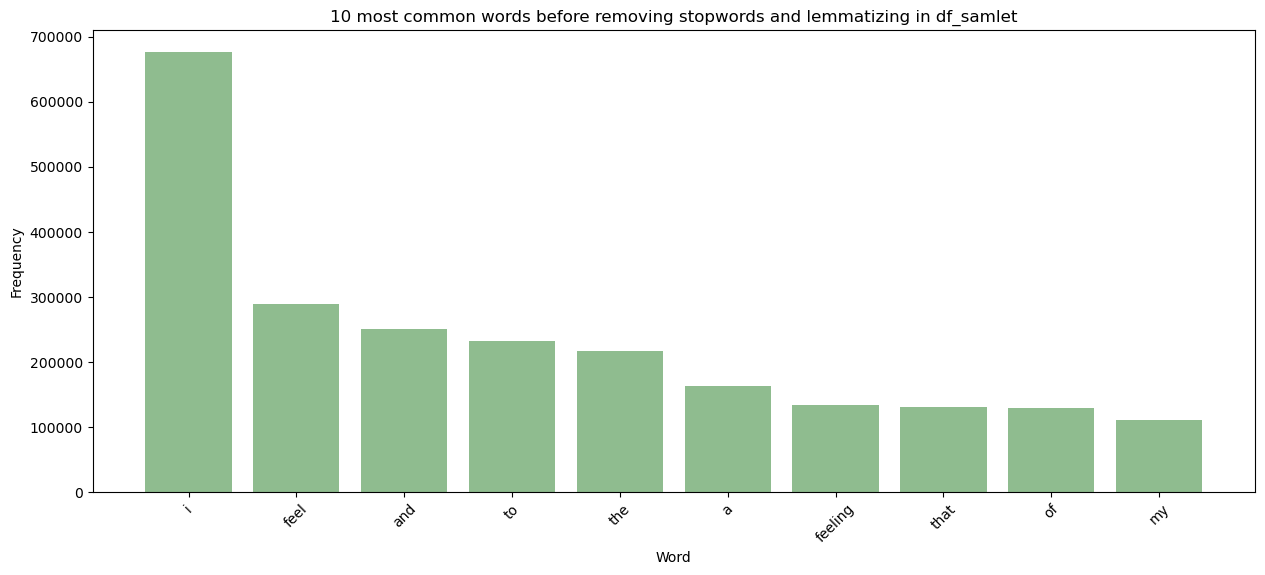

In [30]:
def word_freq(text):
    # Find words and count their frequencies
    words = re.findall(r'\b\w+\b', text)
    word_counts = Counter(words)

    return word_counts

df_samlet['word_freq'] = df_samlet['text'].apply(word_freq)

all_word_counts = Counter()
for freq in df_samlet['word_freq']:
    all_word_counts.update(freq)

most_common_words = all_word_counts.most_common(10)
words = [word for word, _ in most_common_words]
freqs = [count for _, count in most_common_words]


plt.figure(figsize=(15, 6))
plt.bar(words, freqs, color='darkseagreen')
plt.title('10 most common words before removing stopwords and lemmatizing in df_samlet')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [31]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\klykk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\klykk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\klykk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

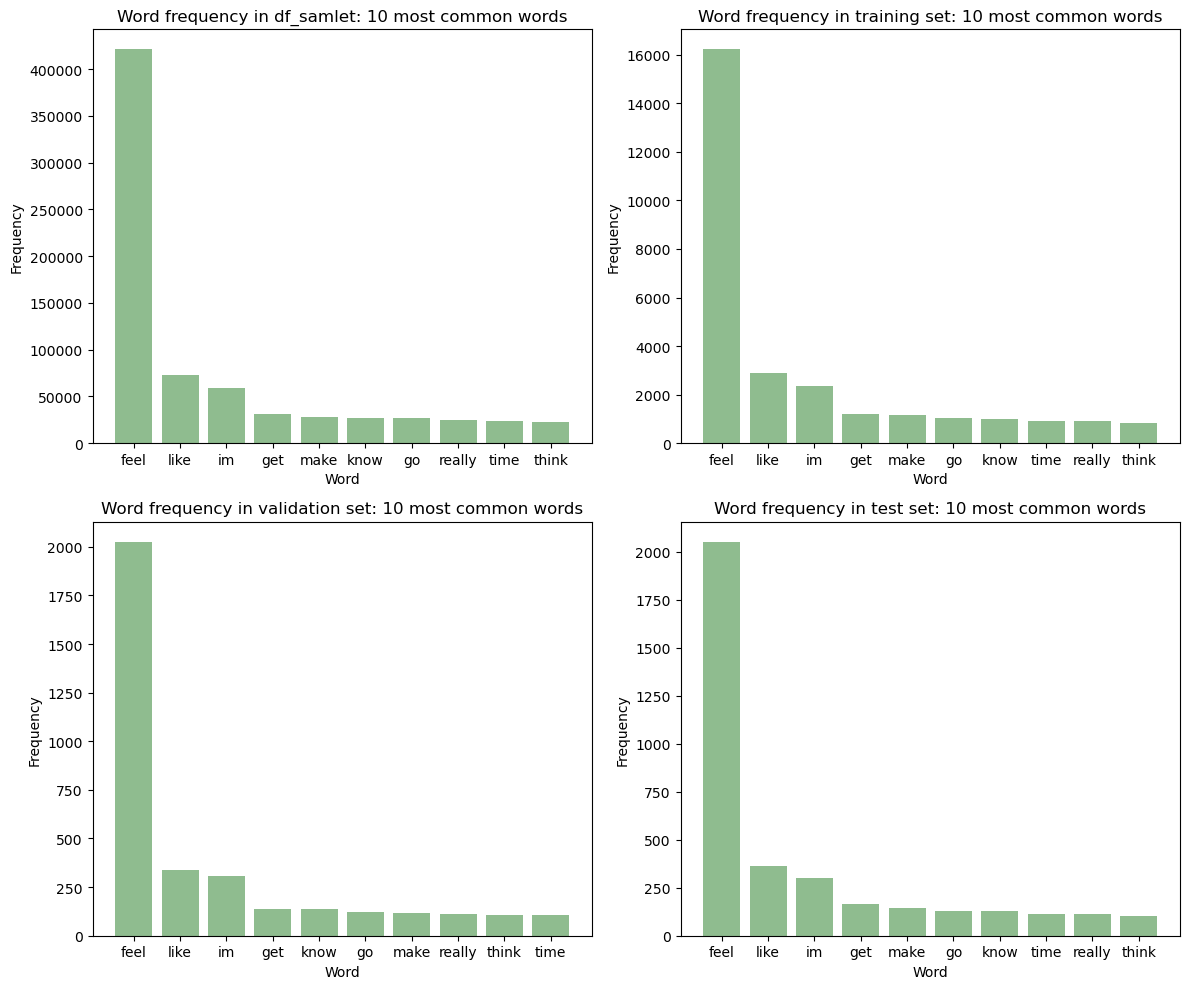

In [33]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def process_text(text):
    tokenized_text = re.findall(r'\b\w+\b', text)
    new_text = [word for word in tokenized_text if word.lower() not in stop_words]
    lemmatized_text = [lemmatizer.lemmatize(word, pos = 'v') for word in new_text]
    return ' '.join(lemmatized_text)


new_df_samlet = df_samlet_no_out.copy()
new_df_train = df_train_no_out.copy()
new_df_val = df_val_no_out.copy()
new_df_test = df_test_no_out.copy()


new_df_samlet['text'] = new_df_samlet['text'].apply(process_text)
new_df_train['text'] = new_df_train['text'].apply(process_text)
new_df_val['text'] = new_df_val['text'].apply(process_text)
new_df_test['text'] = new_df_test['text'].apply(process_text)


#new_df_samlet = new_df_samlet.drop('word_freq', axis=1)
#new_df_train = new_df_train.drop('word_freq', axis=1)
#new_df_val = new_df_val.drop('word_freq', axis=1)
#new_df_test = new_df_test.drop('word_freq', axis=1)


def word_freq(text):
    # Find words and count their frequencies
    words = re.findall(r'\b\w+\b', text)
    word_counts = Counter(words)

    return word_counts

new_df_samlet['word_freq'] = new_df_samlet['text'].apply(word_freq)
new_df_train['word_freq'] = new_df_train['text'].apply(word_freq)
new_df_val['word_freq'] = new_df_val['text'].apply(word_freq)
new_df_test['word_freq'] = new_df_test['text'].apply(word_freq)


all_word_counts_samlet = Counter()
all_word_counts_train = Counter()
all_word_counts_val = Counter()
all_word_counts_test = Counter()


for freq in new_df_samlet['word_freq']:
    all_word_counts_samlet.update(freq)

for freq in new_df_train['word_freq']:
    all_word_counts_train.update(freq)

for freq in new_df_val['word_freq']:
    all_word_counts_val.update(freq)

for freq in new_df_test['word_freq']:
    all_word_counts_test.update(freq)

most_common_words_samlet = all_word_counts_samlet.most_common(10)
words_samlet = [word for word, _ in most_common_words_samlet]
freqs_samlet = [count for _, count in most_common_words_samlet]


most_common_words_train = all_word_counts_train.most_common(10)
words_train = [word for word, _ in most_common_words_train]
freqs_train = [count for _, count in most_common_words_train]


most_common_words_val = all_word_counts_val.most_common(10)
words_val = [word for word, _ in most_common_words_val]
freqs_val = [count for _, count in most_common_words_val]


most_common_words_test = all_word_counts_test.most_common(10)
words_test = [word for word, _ in most_common_words_test]
freqs_test = [count for _, count in most_common_words_test]


# Opret subplots (2 rækker og 2 kolonner)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Bar chart 1
axes[0, 0].bar(words_samlet, freqs_samlet, color='darkseagreen')
axes[0, 0].set_title('Word frequency in df_samlet: 10 most common words')
axes[0, 0].set_xlabel('Word')
axes[0, 0].set_ylabel('Frequency')

# Bar chart 2
axes[0, 1].bar(words_train, freqs_train, color='darkseagreen')
axes[0, 1].set_title('Word frequency in training set: 10 most common words')
axes[0, 1].set_xlabel('Word')
axes[0, 1].set_ylabel('Frequency')

# Bar chart 3
axes[1, 0].bar(words_val, freqs_val, color='darkseagreen')
axes[1, 0].set_title('Word frequency in validation set: 10 most common words')
axes[1, 0].set_xlabel('Word')
axes[1, 0].set_ylabel('Frequency')

# Bar chart 4
axes[1, 1].bar(words_test, freqs_test, color='darkseagreen')
axes[1, 1].set_title('Word frequency in test set: 10 most common words')
axes[1, 1].set_xlabel('Word')
axes[1, 1].set_ylabel('Frequency')

# Juster layout for at få plads til titler og labels
plt.tight_layout()

# Vis plottet
plt.show()